torch.Size([2, 1, 20, 174])


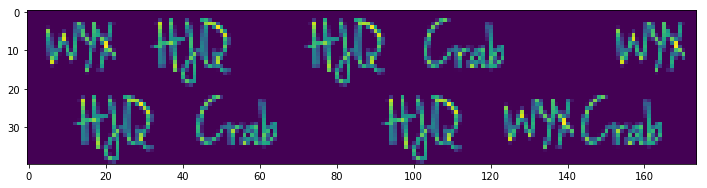

In [140]:
from __future__ import print_function
import math
import matplotlib.cm as cm
from matplotlib import pyplot as plt

# ADD: for the nice progress bar
from ipywidgets import FloatProgress
from IPython.display import display

import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from random import randint


import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import pyro
from pyro.optim import Adam
from pyro.infer import SVI
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.distributions.constraints as constraints
import pyro.infer
from pyro.infer import SVI, Trace_ELBO,  TraceGraph_ELBO
import pyro.optim

%matplotlib inline

# torch.manual_seed(101)

flag_ISM = 0
overlap_flag = 0
nw = 20  # number of words 25
ntr = 25  # number of relative times in a motif 70
nd = 2  # number of documents 
Td= 150 # number of time period
nz = 3


#-----------------------------------------------------------------
plt.rc('figure', figsize=(12.0, 7.0))
def get_size(txt, font):
    test_img = Image.new('L', (1, 1))
    test_draw = ImageDraw.Draw(test_img)
    return test_draw.textsize(txt, font)

def string_to_matrix(s, fontname, fontsize, nw, ntr):
    # Define the Text Color and the Background
    color_text = "White"
    color_background = "Black"
    # Define the image font and resize the nword in a rectangle that suit it
    text = s
    font = ImageFont.truetype(fontname, fontsize)
    width, height = get_size(text, font)
    img = Image.new('L', (ntr, nw), color_background)
    d = ImageDraw.Draw(img)
    d.text((3, height / 10), text, fill=color_text, font=font)
    #d.rectangle((0, 0, width, height))
    path = 'Image_' + text + '.png'
    img.save(path)
    im = Image.open(path).convert('L')
    motif = np.asarray(im, np.float32)  # Motif Matrix
    return motif

# motifs_as_string = ["eggplop", "eggnog", "eggplant", "banana", "apple"]
# motifs_as_string = ["WYX", "Crab","HJQ"]
motifs_as_string = ["WYX", "Crab","HJQ"]
# motifs_as_string = ["WYX"]

nz0 = len(motifs_as_string)

fontname = 'JennaSue.ttf'
fontsize = 18

motifs_as_matrix = [string_to_matrix(st, fontname, fontsize, nw, ntr) for st in motifs_as_string]

# CHANGE: simplified using
motifs = torch.stack([ torch.tensor(m[np.newaxis, :, :]) for m in motifs_as_matrix ], 0).cuda()

# ADD: number of documents

z = torch.zeros(nd,nz0,1,Td).cuda()

# the following tries to generate the clean data(patterns are clear, no overlao)
#clear version
# if overlap_flag == 0:
#     z[0,0,0,1]=1
#     z[0,0,0,99]=1
#     z[0,0,0,30]=1
#     z[0,0,0,70]=1
#     z[0,0,0,149]=1

#     z[1,0,0,90]=1
#     z[1,0,0,10]=1
#     z[1,0,0,40]=1
#     z[1,0,0,120]=1
#     z[1,0,0,140]=1
#     z[0,0,0,1]=1
#     z[0,1,0,99]=1
#     z[0,2,0,30]=1
#     z[0,2,0,70]=1
#     z[0,0,0,149]=1

#     z[1,2,0,90]=1
#     z[1,2,0,10]=1
#     z[1,1,0,40]=1
#     z[1,0,0,120]=1
#     z[1,1,0,140]=1
if overlap_flag == 0:
    z[0,0,0,1]=1
    z[0,1,0,99]=1
    z[0,2,0,30]=1
    z[0,2,0,70]=1
    z[0,0,0,149]=1

    z[1,2,0,90]=1
    z[1,2,0,10]=1
    z[1,1,0,40]=1
    z[1,0,0,120]=1
    z[1,1,0,140]=1
elif overlap_flag == 1:
    #overlap version
    z[0,0,0,20]=1
    z[0,2,0,99]=1
    z[0,1,0,30]=1
    z[0,2,0,70]=1
    z[0,1,0,110]=1
    z[0,0,0,149]=1

    z[1,2,0,90]=1
    z[1,2,0,10]=1
    z[1,1,0,20]=1
    z[1,0,0,120]=1
    z[1,1,0,130]=1
elif overlap_flag == 2:
    #overlap version
    z[0,0,0,20]=1
    z[0,2,0,99]=1
    z[0,1,0,25]=1
    z[0,2,0,70]=1
    z[0,1,0,60]=1
    z[0,1,0,110]=1
    z[0,2,0,130]=1
    z[0,0,0,149]=1

    z[1,2,0,90]=1
    z[1,1,0,85]=1
    z[1,2,0,10]=1
    z[1,1,0,20]=1
    z[1,0,0,50]=1
    z[1,1,0,60]=1
    z[1,0,0,120]=1
    z[1,1,0,130]=1
elif overlap_flag == 3:
    #overlap version
    z[0,0,0,10]=1
    z[0,1,0,20]=1
    z[0,2,0,45]=1
    z[0,1,0,69]=1
    z[0,0,0,80]=1
    z[0,2,0,110]=1
    z[0,1,0,140]=1
    
    z[1,2,0,10]=1
    z[1,1,0,20]=1
    z[1,0,0,50]=1
    z[1,1,0,60]=1
    z[1,2,0,90]=1
    z[1,0,0,130]=1
    z[1,1,0,110]=1

# CHANGE: rename to avoid conflict with a defined variable later
p_w_ta_d0 = F.conv_transpose2d(z,motifs).cuda()
# CHANGE: use (-1) as a shape to let it infer the size
print(p_w_ta_d0.shape)
p_w_ta_d0 = p_w_ta_d0.view(-1)

# CHANGE: don't sample but rather "get the average"
data = 1 * p_w_ta_d0
N = data.sum()

plt.imshow(data.reshape(-1, Td+ntr-1).cpu())


In [2]:
a=np.random.randint(1,30,size=[nz,1,nw,ntr])
print(a[0,0,:,:])

[[3 4 7 8 8 1 7 2 2 1 4 6 1 9 9 4 6 6 5 3 3 1 2 9 8]
 [6 2 9 2 4 9 7 2 9 4 2 4 8 2 4 3 9 2 2 5 6 4 3 5 9]
 [4 5 1 7 2 8 9 4 9 9 9 6 2 8 2 4 6 1 2 5 3 8 5 7 4]
 [1 9 5 4 2 8 4 7 2 6 2 4 7 7 5 4 3 6 6 1 2 8 5 5 8]
 [8 3 7 4 5 6 3 6 1 7 8 4 8 8 9 3 7 9 3 3 3 6 6 4 5]
 [4 1 3 9 6 1 9 7 9 5 2 3 6 6 7 2 9 4 9 2 3 2 8 9 3]
 [2 5 2 1 5 3 1 2 4 8 7 6 8 6 2 6 3 5 8 7 2 3 3 7 8]
 [8 3 6 3 6 8 1 8 9 4 5 3 3 2 7 9 7 4 4 1 7 6 9 3 7]
 [9 2 2 5 6 5 7 4 5 1 9 6 6 9 6 4 1 6 1 6 3 6 8 9 3]
 [5 9 7 1 6 6 4 4 4 7 1 8 8 4 6 3 4 9 8 2 4 1 4 3 6]
 [2 5 9 1 1 1 1 2 8 4 8 7 7 3 8 5 1 6 8 3 4 8 2 7 9]
 [4 8 1 2 6 3 9 4 7 4 5 5 4 3 7 4 7 7 9 5 4 7 9 4 5]
 [8 4 6 8 3 5 9 7 3 1 1 2 4 4 6 9 5 4 7 6 2 3 7 4 6]
 [1 2 1 7 8 6 6 7 5 3 1 9 3 5 2 8 7 8 9 1 5 9 5 3 4]
 [5 6 3 7 2 8 2 2 1 3 2 7 4 9 4 2 1 8 3 6 6 4 9 2 2]
 [2 1 1 5 5 5 4 8 8 6 3 3 1 2 9 3 5 9 2 1 4 7 6 4 1]
 [5 6 5 9 8 4 3 4 4 7 2 1 8 2 8 1 3 3 2 2 5 1 7 3 6]
 [7 2 4 8 3 2 8 3 9 2 7 5 8 2 3 7 4 8 2 4 7 4 1 6 2]
 [2 6 1 2 1 5 2 8 9 5 1 6 6 6 7 9 1 3 8 1 4 9 

In [180]:
fin_motif = []
min_loss = 99999999999
best_ite = -1
all_loss = []
all_motif = []

for ite in range(5):
    if ite == 0:
        init_motif = np.ones((nz,1,nw,ntr))
#         print(init_motif[0,0,:,:])
    else:
        init_motif = np.random.randint(1,30,size=[nz,1,nw,ntr])
#         print(init_motif[0,0,:,:])
    init_motif = torch.from_numpy(init_motif).cuda()
    init_motif = init_motif.type_as(torch.ones(nd,nz,1,Td).cuda())
    
    tem_loss = []
    def p_w_ta_d(z,motifs):
        t = F.conv_transpose2d(z,motifs)
        return t.view(-1)
    # ADD: introduce some variables
    prior0 = 0.1*N/nd / nz / Td
    prior1 = 0.1*N/nz / nw / ntr
    #randinit = 0

    def model(data):
        s0 = (nd, nz, 1, Td)
        s1 = (nz, 1, nw, ntr)
        alpha0 = torch.ones(*s0).cuda()
        alpha1 = torch.ones(*s1).cuda()
        z = pyro.sample("latent0", pdist.Dirichlet(concentration=alpha0.view(nd, -1)))
        motifs = pyro.sample("latent1", pdist.Dirichlet(concentration=alpha1.view(nz, -1)))

        z = z.reshape(*s0)
        motifs = motifs.reshape(*s1)
        p = p_w_ta_d(z, motifs)
        with pyro.iarange("data", len(data)):
            zts = pyro.sample("zts", pdist.Categorical(probs=z))
            pyro.sample("observe", pdist.Multinomial(probs=p), obs=data)

    # Give the initialization

    step_motif_count = 0
    tem_motif = []

    def guide(data):
        qalpha0 = pyro.param("qalpha0", torch.ones(nd,nz,1,Td).cuda(), constraint=constraints.positive) # z_ts table
        global step_motif_count
        if flag_ISM:
            qalpha1 = pyro.param("qalpha1", init_motif, constraint=constraints.positive) # motif
            if step_motif_count%5 == 0:
                tem_motif.append(qalpha1)
        else:
            qalpha1 = pyro.param("qalpha1",  init_motif, constraint=constraints.positive) # motif
            if step_motif_count%5 == 0:
                tem_motif.append(qalpha1)

    #     CHANGE: use the fact that dirichlet can draw independant dirichlets
        pyro.sample("latent0",pdist.Dirichlet(concentration=qalpha0.view(nd, -1)))
        pyro.sample("latent1",pdist.Dirichlet(concentration=qalpha1.view(nz, -1)))
    def show_motifs():
        infer_motifs = np.load("qalpha1.npy")
        for i in range(nz):
            plt.figure(i)
            locals()['infer_motif' +str(i)] = infer_motifs[i,0,:,:]
            plt.imshow(-locals()['infer_motif' +str(i)],cmap = "gray")
            plt.xticks([])
            plt.yticks([])
            plt.show()
    def show_real_motifs():
        for i in range(nz):
            plt.figure(i)
            locals()['real_motif' +str(i)] =  motifs[0,0,:,:].cpu().numpy()
            plt.imshow(-locals()['real_motif' +str(i)],cmap = "gray")
            plt.xticks([])
            plt.yticks([])
            plt.show()
            
    # CHANGE: change adam params
    pyro.clear_param_store()
    adam_params = {"lr": 0.08}
    optimizer = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    n_steps = 100
    pro = FloatProgress(min=0, max=n_steps-1)
    display(pro)
    
    for step in range(n_steps):
        loss = svi.step(data)
        tem_loss.append(loss)
        pro.value += 1
        pro.description = str(step)
        
    all_motif.append(tem_motif)
    tem = min(tem_loss)
    all_loss.append(tem_loss)
    if tem < min_loss:
        min_loss = tem
        best_ite = ite
        fin_motif = tem_motif

FloatProgress(value=0.0, max=99.0)

FloatProgress(value=0.0, max=99.0)

FloatProgress(value=0.0, max=99.0)

FloatProgress(value=0.0, max=99.0)

FloatProgress(value=0.0, max=99.0)

In [181]:
print(best_ite)
print(all_loss[0])
# a = all_motif[3].detach().cpu().numpy()
# plt.imshow(a[0][0])


0
[1786753393.1875, 1748760420.6450195, 1692784924.4692383, 1609574356.265625, 1588451803.519043, 1531306475.631836, 1530656484.2905273, 1450335837.6269531, 1445718000.628418, 1421887332.4472656, 1419117781.350586, 1375669656.1254883, 1377488361.3725586, 1328329672.682129, 1329006663.0800781, 1313466755.0478516, 1295287530.0239258, 1279658772.5668945, 1269159969.7597656, 1256549091.7753906, 1246936550.9223633, 1222994893.1660156, 1218220769.4829102, 1179674687.0615234, 1184511869.5551758, 1186271763.9995117, 1162369174.7524414, 1144832668.418457, 1133587055.5341797, 1124295935.8422852, 1110196960.541504, 1105422286.7895508, 1092674766.7026367, 1079143491.2202148, 1066954249.1489258, 1062576005.3461914, 1047928005.4174805, 1037712847.2944336, 1028793062.0043945, 1006638143.1435547, 987178939.2055664, 985880473.6293945, 959597162.7231445, 939406418.3120117, 930126592.0463867, 916659676.5351562, 896479705.8378906, 869270072.1254883, 861867605.5625, 844208413.2792969, 823958441.9550781, 79

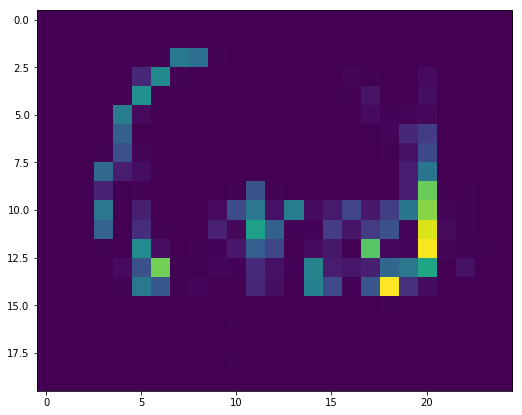

In [235]:
cmp_motif = np.array(all_motif[0])
plt.imshow(cmp_motif[99][2][0].detach().cpu().numpy())

In [93]:
plt.imshow(motifs[1,0,:,:].cpu())

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [128]:
print(np.exp(3))

20.085536923187668


In [236]:
def cal_median_KL(i):
    KL = []
#     infer_motif0 = infer_motif[0,0,:,:]cmp_motif[99][1][0].detach().cpu().numpy()
#     infer_motif1 = infer_motif[1,0,:,:]
#     infer_motif2 = infer_motif[2,0,:,:]
    infer_motif0 = cmp_motif[i][0][0].detach().cpu().numpy()
    infer_motif1 = cmp_motif[i][1][0].detach().cpu().numpy()
    infer_motif2 = cmp_motif[i][2][0].detach().cpu().numpy()
    
    norm_infer_motif0 = infer_motif0/infer_motif0.sum()
    norm_infer_motif1 = infer_motif2/infer_motif2.sum()
    norm_infer_motif2 = infer_motif1/infer_motif1.sum()
    normalizer = 0
    for n in range(nz):
        temKL = 0
        real_motif = motifs[n,0,:,:].cpu()
        norm_real_motif = real_motif/real_motif.sum()
        for i in range(nw):
            for j in  range(ntr):
                if norm_real_motif[i,j] == 0:
                    temKL += 0
                else:
                    normalizer += norm_real_motif[i,j] +  locals()['norm_infer_motif'+str(n)][i,j]
                    temKL += norm_real_motif[i,j] * (np.log(norm_real_motif[i,j]/ locals()['norm_infer_motif'+str(n)][i,j]))
        temKL = temKL/normalizer
        KL.append(temKL)
#     print(min(KL))
    mean_KL = np.sum(KL)/nz
    
#     norm_KL = 1-np.exp(-mean_KL)
    return mean_KL
final_data = []
cmp_motif = np.array(all_motif[0])
for i in range(n_steps):
#     tem = tem_motif[i]
#     tem = tem.cpu().detach().numpy()
    tem_rec = cal_median_KL(i)
    final_data.append(tem_rec.item())
print(final_data)

[0.7753310998280843, 0.7393534978230795, 0.7112540404001871, 0.6869306564331055, 0.6646465063095093, 0.6443410714467367, 0.625679095586141, 0.608792265256246, 0.5933761596679688, 0.5796433289845785, 0.5672097603480021, 0.5552500089009603, 0.5437812805175781, 0.5329803625742594, 0.5227365493774414, 0.5126254558563232, 0.5031172037124634, 0.4938470125198364, 0.4853983720143636, 0.4769010941187541, 0.4686007499694824, 0.46024401982625324, 0.45288105805714923, 0.4454895655314128, 0.4383832613627116, 0.4320027033487956, 0.42579372723897296, 0.41936540603637695, 0.4130380153656006, 0.40675826867421466, 0.4005115032196045, 0.3949185212453206, 0.38968463738759357, 0.3848042885462443, 0.38017189502716064, 0.37532226244608563, 0.370183269182841, 0.36549214522043866, 0.3608221610387166, 0.3564891815185547, 0.35228657722473145, 0.3481629689534505, 0.34432049592336017, 0.3409239848454793, 0.3378671010335286, 0.33544305960337323, 0.3337528705596924, 0.3327028751373291, 0.33208094040552777, 0.3320328

In [ ]:
print(final_data)